<a href="https://colab.research.google.com/github/dane-meister/Machine-Learning-Algos/blob/main/behavior_learning_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Behavior Cloning from Numerical States
Using imported dataset, implements a basic behavior cloning policy. The robot's task is reaching to the block and trying to grasp it.


**Check whether you are connected to a GPU runtime**

For this implementation, we **don't** need GPU.

If you want to use GPU, and the cell below (after you run it) says False, you need to go to top right (where it shows "RAM", "Disk" or "Connect"). Click the drop down and then "Change runtime type". Select "T4 GPU". If it warns you delete the current runtime, click "OK".

In [9]:
import torch
torch.cuda.is_available()

True

**Install dependencies**

It takes ~10 mins to install pybullet for the first time. Be patient. You will see the elapsed time in the status bar at the bottom of this page.

In [10]:
!pip install ftfy regex tqdm fvcore imageio moviepy
!pip install -U --no-cache-dir gdown --pre
!pip install pybullet
!pip install easydict
!pip install imageio-ffmpeg

**Download 3d models**


In [11]:
import os
if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip

**Download prepared simulated environment implementation**

In [12]:
import os
if not os.path.exists('env'):
  !gdown --id --folder 1lTSXnzcxmhHde0ZciDUjwuGpWKYcca9q

**Download dataset**

In [13]:
import os
if not os.path.exists('pa1_grasp_dataset.pkl'):
  !gdown --id 1lXRLmG1uGrTir9CkLXYgJV9-JSmZ2KTQ

In [14]:
# import needed packages

import torch        # for machine learning
import numpy as np  # for basic arrays
import pickle       # for loading data

from env import PickObjectEnv # import the simulated environment

In [15]:
# function to load our behavior cloning dataset
def load_dataset(dataset_filename):
    with open(dataset_filename, "rb") as f:
        dataset = pickle.load(f)
        return dataset

# load the dataset
dataset = load_dataset("pa1_grasp_dataset.pkl")


# The dataset format is like below
# data = {
#   "image_obs": np.ndarray,
#   "joint_state": np.ndarray,
#   "position_state": np.ndarray,
#   "action": np.ndarray
# }

print (f"# datapoints in the dataset: {len(dataset['image_obs'])}")
print (f"Shape of image observations {dataset['image_obs'].shape}") # should be (N, 240, 240, 3)
print (f"Shape of states {dataset['joint_state'].shape}")           # should be (N, 10)
print (f"Shape of states {dataset['position_state'].shape}")        # should be (N, 6)
print (f"Shape of actions {dataset['action'].shape}")               # should be (N, 4), 3 for moving direction and 1 for the gripper

# datapoints in the dataset: 1900
Shape of image observations (1900, 240, 240, 3)
Shape of states (1900, 10)
Shape of states (1900, 6)
Shape of actions (1900, 4)


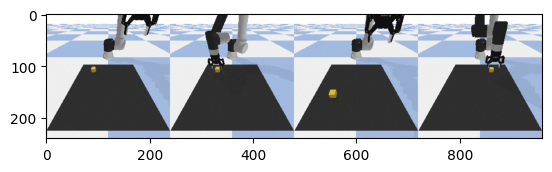

In [16]:
# Takes a look at several samples in the dataset
import matplotlib.pyplot as plt
%matplotlib inline
indices = [0,30,300,1000]
sample_image = np.hstack([i for i in dataset["image_obs"][indices]])
plt.imshow(sample_image)

In [17]:
# split the data into training and evaluation set
# we'll naively use the first 80% to train and last 20% for evaluation
dataset_len = len(dataset["image_obs"])
train_len = int(dataset_len*0.8)
# training set
train_set = {
    "image_obs": dataset["image_obs"][:train_len],
    "joint_state": dataset["joint_state"][:train_len],
    "position_state": dataset["position_state"][:train_len],
    "action": dataset["action"][:train_len]
}
# evaluation set
eval_set = {
    "image_obs": dataset["image_obs"][train_len:],
    "joint_state": dataset["joint_state"][train_len:],
    "position_state": dataset["position_state"][train_len:],
    "action": dataset["action"][train_len:]
}

# check them
print (f"intended training set length {train_len}")
print (f"# datapoints in the training set: {len(train_set['image_obs'])}")
print (f"# datapoints in the evaluation set: {len(eval_set['image_obs'])}")

intended training set length 1520
# datapoints in the training set: 1520
# datapoints in the evaluation set: 380


In [34]:
# an example base class
class Algorithm:

    def __init__(self, model=None):
        self.model = model # model

    def policy(self, input_state: np.ndarray) -> np.ndarray:
        """
        args:
        input_state: input state in shape (B, D) where N is the length of the batch and D is the dimension of the state (feature)
        return:
        an np.ndarray action vector in shape (B, 4)
        """
        raise NotImplementedError

    # train (using neural network) or initialize (using linear regression / nearest neighbor) your model
    def train(self, train_set):
        pass

    # method to evaluate policy
    def eval(self, eval_set, input_state_type="position_state"):
        eval_len = len(eval_set["image_obs"])
        errors = []
        for i in range(eval_len):
            obs = eval_set[input_state_type][i]
            target_action = eval_set["action"][i]
            pred_action = self.policy(obs[None,])[0]
            errors.append(np.linalg.norm(target_action - pred_action))
        print (f"Evaluation on dataset, errors: {np.mean(errors):.4f}")

    # evaluate in an environment
    def eval_in_env(self, input_state_type="position_state", eval_num=3):
        config = {
            "pick": ["yellow block"] # currently supports {red, blue, green, yellow}
        }
        env = PickObjectEnv()
        all_rewards = []
        for eval_ep in range(eval_num):
            obs = env.reset(config)
            done = False
            rewards = 0
            step_count = 0
            while step_count < 80: # reduce this if it takes to long to evaluate
                input_state = self.get_input_state_from_obs(obs, input_state_type)[None, :]
                action = self.policy(input_state)[0]
                if not isinstance(action, np.ndarray) or action.shape != (4,):
                  raise ValueError(f"Action must be a np.ndarray of shape (4,), but got: {action}")
                obs, reward, done, _, _ = env.step(action)
                rewards += reward
                step_count += 1
            all_rewards.append(rewards)
            env.show_env_record()
            obs = env.reset(config)
        print (f"Evaluation on envs, result: {np.mean(all_rewards):.4f} +/- {np.std(all_rewards):.4f}")


    def get_input_state_from_obs(self, obs, input_state_type):
        if input_state_type == "joint_state":
            return np.concatenate([obs["joint_state"], obs["block_position"]])
        elif input_state_type == "position_state":
            return np.concatenate([obs["ee_position"], obs["block_position"]])
        elif input_state_type == "image_obs":
            return obs["image_obs"]


## 1. Nearest neighbor using position states

First use "position_states" in the given dataset because it is easier for the model.
Since the task is to reach and grasp the target block, the positions of the robot arm (end-effector) and the target block are enough to describe the environment.
The "position_states" in the dataset are designed to contain such information.
As shown above, they are in the shape of (N, 6).
N is the length of the whole dataset, so let's focus on (6), the dimension of each state.
The first 3 dimensions correspond to the coordinates of the end effector of the robot arm. The last 3 correspond to the coordinates of the target block.

Here we write a nearest neighbor algorithm that takes in a state, and finds the target action according to its nearest neighbor in the training set.

Summary:

- Input: "position_states"
- Output: "action"
- Algorithm: nearest neighbor

In [35]:
class NearestNeighbor(Algorithm):
    def __init__(self, model=None):
        self.train_set = None

    def policy(self, input_state: np.ndarray) -> np.ndarray:
        # Shape of input_state: (1, D) np.ndarray, D is the dimension of state vector
        # Shape of the desired output: (1, 4) np.ndarray
        if self.train_set is None:
            raise ValueError("No training data available.")

        # Extract the relevant data arrays
        train_states = self.train_set["position_state"]
        train_actions = self.train_set["action"]

        # Calculate the Euclidean distance between the input state and all training states
        distances = np.linalg.norm(train_states - input_state, axis=1)

        # Find the index of the nearest neighbor
        nearest_neighbor_index = np.argmin(distances)

        # Return the action associated with the nearest neighbor
        nearest_neighbor_action = train_actions[nearest_neighbor_index]
        nearest_neighbor_action = nearest_neighbor_action.reshape(1, 4)
        return nearest_neighbor_action

    def train(self, train_set):
        self.train_set = train_set

nearest_neighbor_algorithm = NearestNeighbor()
nearest_neighbor_algorithm.train(train_set)
nearest_neighbor_algorithm.eval(eval_set)
nearest_neighbor_algorithm.eval_in_env(input_state_type="position_state", eval_num=3) # optinally you can test in the env!

Evaluation on dataset, errors: 0.2127
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Evaluation on envs, result: 0.3131 +/- 0.0159


## 2. Linear regression using position states
Let's move a step further to use linear regression for the same type of input (position states)

Summary:

- Input: "position_states"
- Output: "action"
- Algorithm: Linear Regression

In [38]:
import torch.nn as nn
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = train_set['position_state'].shape[1]
        self.out_dim = train_set['action'].shape[1]
        self.model = nn.Linear(self.input_dim, self.out_dim)

    def forward(self, x):
        # calculate the predicted action from the input state (x)
        prediction = self.model(x)
        return prediction

class LinearRegression(Algorithm):
    def __init__(self, model: LinearRegressionModel):
        self.model = model

    def policy(self, input_state: np.ndarray) -> np.ndarray:
        # Convert the input state to a PyTorch tensor
        input_state = torch.Tensor(input_state)

        # Make a prediction using the trained model
        output_action = self.model(input_state).detach().numpy()

        return output_action


    def train(self, train_set):
        self.train_set = train_set

        learning_rate = 0.001
        num_steps = 3000
        batch_size = 256

        # Extract the training data
        train_inputs = torch.Tensor(train_set['position_state'])
        train_outputs = torch.Tensor(train_set['action'])

        # Initialize the model and optimizer
        model = self.model
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Define the loss function
        loss_function = nn.MSELoss()

        for step_index in range(num_steps):
            # Generate random batch indices
            batch_indices = torch.randint(high=len(train_inputs), size=[batch_size])

            # Select the inputs and corresponding outputs for the batch
            x_batch = train_inputs[batch_indices]
            y_batch = train_outputs[batch_indices]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(x_batch)

            # Compute the loss for this batch
            loss = loss_function(predictions, y_batch)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()


linear_regression_model = LinearRegressionModel()
linear_regression_algorithm = LinearRegression(linear_regression_model)
linear_regression_algorithm.train(train_set)
linear_regression_algorithm.eval(eval_set)
linear_regression_algorithm.eval_in_env(input_state_type="position_state", eval_num=3) # optinally you can test in the env!

Evaluation on dataset, errors: 0.0727
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Evaluation on envs, result: 866.9024 +/- 47.1489


## 3. "Deep" Learning: Multi-Layer Perceptron (MLP) using position states
Now let's see how a deep learning approach solves this problem.

Summary:

- Input: "position_state"
- Output: "action"
- Algorithm: MLP

In [39]:
import torch.nn as nn
class MLPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = train_set['position_state'].shape[1]
        self.out_dim = train_set['action'].shape[1]
        self.hidden_dim = 128
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.out_dim)
        )

    def forward(self, x):
        prediction = self.model(x)
        return prediction

class MLP(Algorithm):
    def __init__(self, model: MLPModel):
        self.model = model

    def policy(self, input_state: np.ndarray) -> np.ndarray:
         # Convert the input state to a PyTorch tensor
        input_state = torch.Tensor(input_state)

        # Make a prediction using the trained model
        output_action = self.model(input_state).detach().numpy()

        return output_action

    def train(self, train_set):
        self.train_set = train_set

        learning_rate = 0.001
        num_steps = 2000
        batch_size = 64

        # Extract the training data
        train_inputs = torch.Tensor(train_set['position_state'])
        train_outputs = torch.Tensor(train_set['action'])

        # Initialize the model and optimizer
        model = self.model
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Define the loss function
        loss_function = nn.MSELoss()

        for step_index in range(num_steps):
            # Generate random batch indices
            batch_indices = torch.randint(high=len(train_inputs), size=[batch_size])

            # Select the inputs and corresponding outputs for the batch
            x_batch = train_inputs[batch_indices]
            y_batch = train_outputs[batch_indices]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(x_batch)

            # Compute the loss for this batch
            loss = loss_function(predictions, y_batch)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

mlp_model = MLPModel()
mlp_algorithm = MLP(mlp_model)
mlp_algorithm.train(train_set)
mlp_algorithm.eval(eval_set, input_state_type="position_state")
mlp_algorithm.eval_in_env(input_state_type="position_state", eval_num=3) # optinally you can test in the env!

Evaluation on dataset, errors: 0.0458
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Evaluation on envs, result: 0.3139 +/- 0.0247


## 4. Using joint states

Now let's try a bit more challenging situation: we move to use joint states instead of positions of the robot.

We will use "joint_state" in the dataset.
The "joint_state" has shape (N, 10), and we will look into (10), which is the dimension of each state.
The first 7 dimensions discribe the status of the robot.
Within it, the first 6 dimensions describe the rotation angles of 6 joints in the robot, and the last dimension indicates the status of the gripper (1 for activated/closed and 0 for deactivated/released).
The last 3 dimensions of the state represents the coordinates of the target block.

The objective is to regress target action out of given "joint_state".

Summary:

- Input: "joint_state"
- Output: "action"
- Algorithm: MLP

In [40]:
import torch.nn as nn
class MLPModelJointState(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = train_set['joint_state'].shape[1]
        self.out_dim = train_set['action'].shape[1]
        self.hidden_dim = 128
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.out_dim)
        )


    def forward(self, x):
        prediction = self.model(x)
        return prediction


class MLPJointState(Algorithm):
    def __init__(self, model: MLPModelJointState):
        self.model = model

    def policy(self, input_state: np.ndarray) -> np.ndarray:
        # Shape of input_state: (1, D) np.ndarray, D is the dimension of state vector, which is 10 in this part
        # Shape of the desired output: (1, 4) np.ndarray
        input_state = torch.Tensor(input_state)
        output_action = self.model(input_state).detach().numpy()
        return output_action

    def train(self, train_set):
        self.train_set = train_set

        learning_rate = 0.001
        num_steps = 2000
        batch_size = 64

        # Extract the training data
        train_inputs = torch.Tensor(train_set['joint_state'])
        train_outputs = torch.Tensor(train_set['action'])

        # Initialize the model and optimizer
        model = self.model
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Define the loss function
        loss_function = nn.MSELoss()

        for step_index in range(num_steps):
            # Generate random batch indices
            batch_indices = torch.randint(high=len(train_inputs), size=[batch_size])

            # Select the inputs and corresponding outputs for the batch
            x_batch = train_inputs[batch_indices]
            y_batch = train_outputs[batch_indices]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(x_batch)

            # Compute the loss for this batch
            loss = loss_function(predictions, y_batch)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

mlp_joint_state_model = MLPModelJointState()
mlp_joint_state_algorithm = MLPJointState(mlp_joint_state_model)
mlp_joint_state_algorithm.train(train_set)
mlp_joint_state_algorithm.eval(eval_set, input_state_type="joint_state")
mlp_algorithm.eval_in_env(input_state_type="position_state", eval_num=3) # optinally you can test in the env!

Evaluation on dataset, errors: 0.0646
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Evaluation on envs, result: 0.3242 +/- 0.0399
